In [2]:
# Standard python numerical analysis imports:
import numpy as np
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz

# the ipython magic below must be commented out in the .py file, since it doesn't work.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pandas as pd

In [4]:
data = pd.read_csv('MidOhio2011Qual.csv',header=11)
data.head()

/Users/DillonBrout/anaconda/lib/python3.4/site-packages/pandas/io/parsers.py:1159: DtypeWarning: Columns (0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


,Time,Distance,Lap Number,Lap Time,Corr Speed,Engine RPM,Aero Front Percentage,Aero Total,Ride Height Front,Ride Height Rear,...,Wheel Load LR,Wheel Load RR,Damper Pos FL,Damper Pos FR,Damper Pos LR,Damper Pos RR,Tire Pres LF,Tire Pres LR,Tire Pres RF,Tire Pres RR
0,s,ft,NaN,s,mph,rpm,%,lbf,mm,mm,...,lb,lb,mm,mm,mm,mm,psi,psi,psi,psi
1,0.000,0,628,0.00,0.0,420,NaN,NaN,45.95,61.20,...,NaN,NaN,0.47,0.27,-1.33,-2.86,23.42,26.32,26.32,26.32
2,0.010,0,628,0.00,0.0,420,NaN,NaN,45.93,61.25,...,NaN,NaN,0.47,0.27,-1.33,-2.86,23.42,26.32,26.32,26.32
3,0.020,0,628,0.00,0.0,420,NaN,NaN,45.90,61.30,...,NaN,NaN,0.47,0.27,-1.33,-2.86,23.42,26.32,26.32,26.32
4,0.030,0,628,0.00,0.0,420,NaN,NaN,45.93,61.30,...,NaN,NaN,0.47,0.27,-1.33,-2.86,23.42,26.32,26.32,26.32


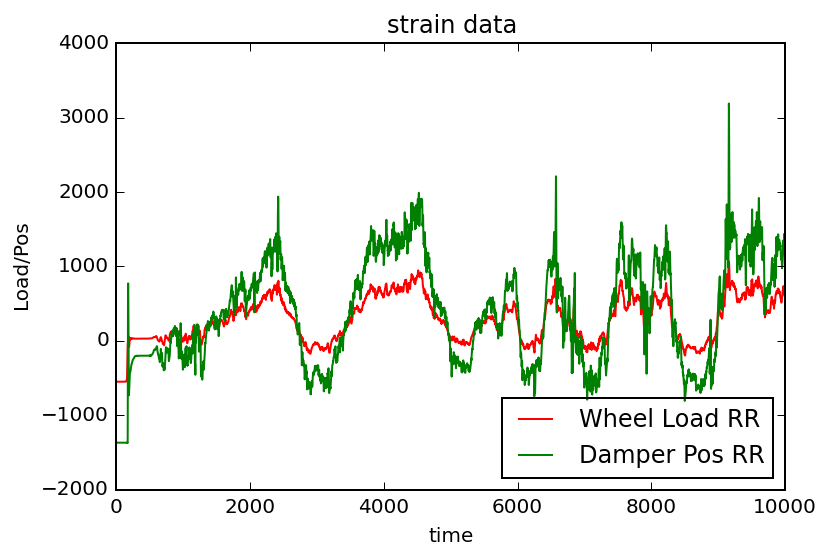

In [5]:
WLRR = data['Wheel Load RR'][40000:50000]
DPRR = data['Damper Pos RR'][40000:50000]
ww = np.arange(3000,3200)

plt.figure()
plt.plot(np.arange(len(WLRR)),WLRR,'r',label='Wheel Load RR')
plt.plot(np.arange(len(DPRR)),100*DPRR,'g',label='Damper Pos RR')
plt.xlabel('time')
plt.ylabel('Load/Pos')
plt.legend(loc='lower right')
plt.title('strain data')
plt.savefig('strain.png')

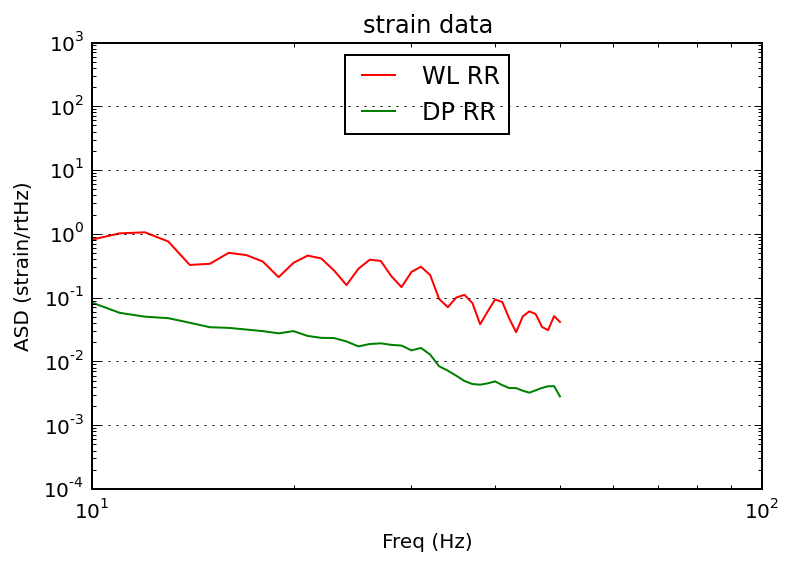

In [6]:
# sampling rate:
fs = 100
# the time sample interval (uniformly sampled!)
dt = 1./fs
# number of sample for the fast fourier transform:
NFFT = 1*fs
fmin = 10
fmax = 100

WLRR = np.array(WLRR,dtype='float')
DPRR = np.array(DPRR,dtype='float')

Pxx_WLRR, freqs = mlab.psd(WLRR, Fs = fs, NFFT = NFFT)
Pxx_DPRR, freqs = mlab.psd(DPRR, Fs = fs, NFFT = NFFT)

# We will use interpolations of the ASDs computed above for whitening:
psd_WLRR = interp1d(freqs, Pxx_WLRR)
psd_DPRR = interp1d(freqs, Pxx_DPRR)

# plot the ASDs:
plt.figure()
plt.loglog(freqs, np.sqrt(Pxx_WLRR),'r',label='WL RR')
plt.loglog(freqs, np.sqrt(Pxx_DPRR),'g',label='DP RR')
plt.axis([fmin, fmax, 1e-4, 1e3])
plt.grid('on')
plt.ylabel('ASD (strain/rtHz)')
plt.xlabel('Freq (Hz)')
plt.legend(loc='upper center')
plt.title('strain data')
plt.savefig('ASDs.png')

In [7]:

# function to writen data
def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)

    # whitening: transform to freq domain, divide by asd, then transform back, 
    # taking care to get normalization right.
    hf = np.fft.rfft(strain)
    white_hf = hf / (np.sqrt(interp_psd(freqs) /dt/2.))
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

# now whiten the data from H1 and L1, and also the NR template:
WLRR_whiten = whiten(WLRR,psd_WLRR,dt)
DPRR_whiten = whiten(DPRR,psd_DPRR,dt)


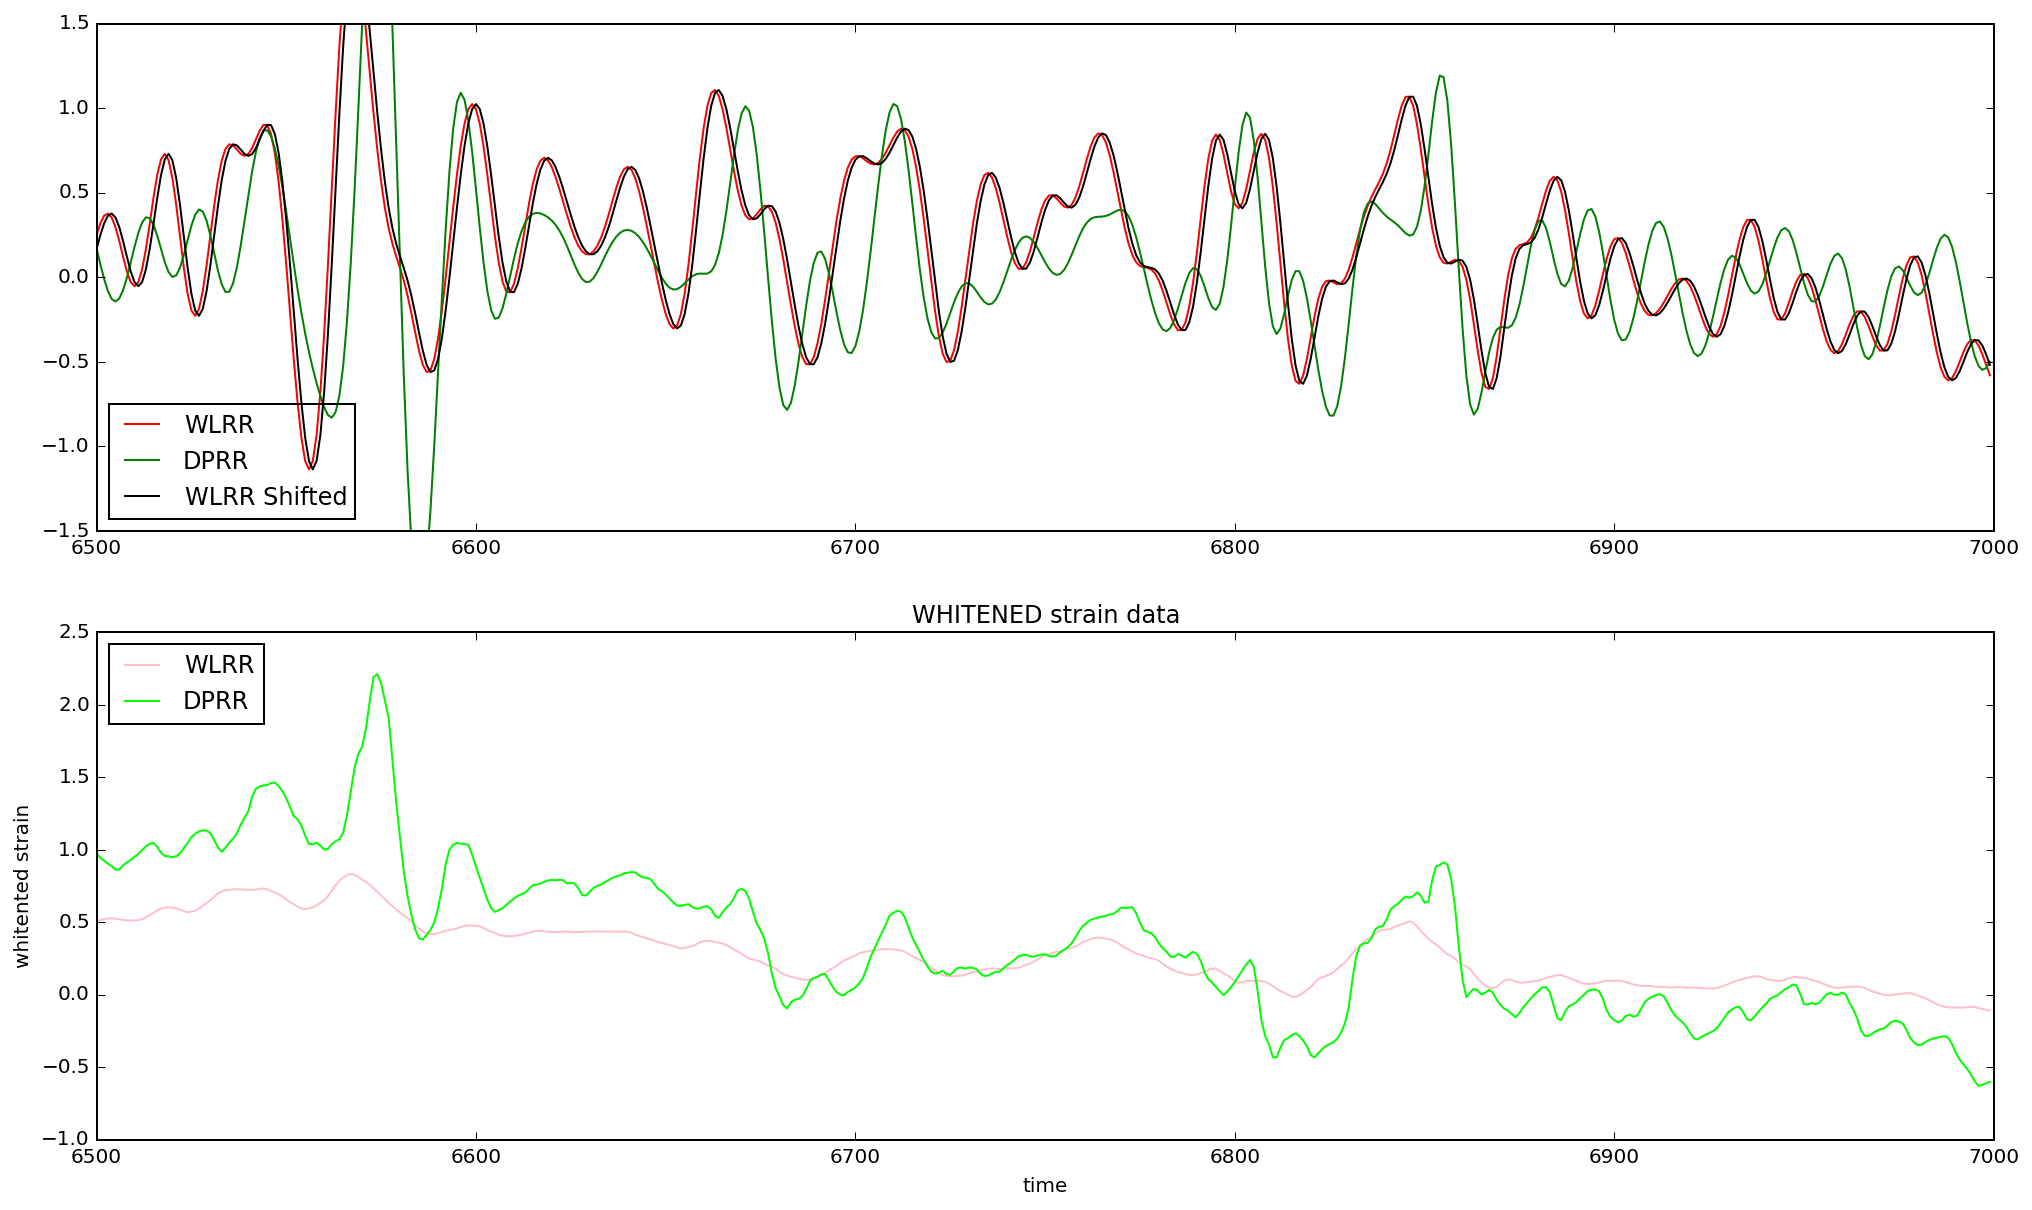

In [9]:
############################################################################################################
# YOU CAN LOOP HERE BY SUPPRESSING DIFFERENT FREQUENCIES AND CALCULATING AUTOCORRELATION AT DIFFERENT FREQ 
# TO GET PHASE ANGLE FOR MANY DIFFERENT FREQUENCY BANDS
############################################################################################################
# We need to suppress the high frequencies with some bandpassing:
# need to investigate here how the autocorr offset changes with band suppression
bb, ab = butter(4, [.1*2./fs, 7.*2./fs], btype='band')

WLRR_whitenbp = filtfilt(bb, ab, WLRR_whiten)
DPRR_whitenbp = filtfilt(bb, ab, DPRR_whiten)

WLRRbp = filtfilt(bb, ab, WLRR)
DPRRbp = filtfilt(bb, ab, DPRR)

# plot the data after whitening:
# first, shift L1 by 7 ms, and invert. See the GW150914 detection paper for why!
WLRR_shift = np.roll(WLRR_whitenbp,int(0.017*fs))

x = np.arange(len(WLRR_whitenbp))

ww = np.arange(6500,7000)

fig,(ax1,ax2) = plt.subplots(2,figsize=(17,10))
ax1.plot(x[ww],WLRR_whitenbp[ww],'r',label='WLRR')
ax1.plot(x[ww],DPRR_whitenbp[ww],'g',label='DPRR')
ax1.plot(x[ww],WLRR_shift[ww],color='black',label='WLRR Shifted')

#ax2.plot(x[ww],WLRRbp[ww]/100.,'r',label='WLRR')
ax2.plot(x[ww],WLRR[ww]/1000.,color='pink',label='WLRR')
#ax2.plot(x[ww],DPRRbp[ww]/10.,'g',label='DPRR')
ax2.plot(x[ww],DPRR[ww]/10.,color='lime',label='DPRR')

#plt.xlim([-0.1,0.05])
ax1.set_ylim([-1.5,1.5])
plt.xlabel('time')
plt.ylabel('whitented strain')
ax1.legend(loc='lower left')
ax2.legend(loc='upper left')
plt.title('WHITENED strain data')
plt.savefig('strain_whitened.png')